## Smart Attendance Using Voice Recognition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os

In [2]:
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd
from itertools import cycle

### Audio Files Information

In [3]:
audio_files=glob("Voice_Dataset/50_speakers_audio_data/**/*.wav")
print("Total Audio Files : ",len(audio_files))
print(audio_files[:2])

Total Audio Files :  2511
['Voice_Dataset/50_speakers_audio_data\\Speaker0026\\Speaker26_000.wav', 'Voice_Dataset/50_speakers_audio_data\\Speaker0026\\Speaker26_001.wav']


### Audio Sample from Dataset


In [4]:
print(os.path.basename(os.path.dirname(audio_files[100])))
ipd.Audio(audio_files[100])

Speaker0028


### Audio Sample Details


In [5]:
print("AUDIO OF",os.path.basename(os.path.dirname(audio_files[100])))
y, sr=librosa.load(audio_files[100])
print("Audio Signal :",y[:5]) # It has values of each point of wave of sound 
print("Audio sample per second :",sr) # Just like FPS in videos(footage per sec)
# librosa automatically resamples the audio to 22050 Hz.

AUDIO OF Speaker0028


Audio Signal : [-0.02514648  0.00808716  0.05288696 -0.01272583 -0.06106567]
Audio sample per second : 22050


### Audio Waveform (Full & Zoomed View)

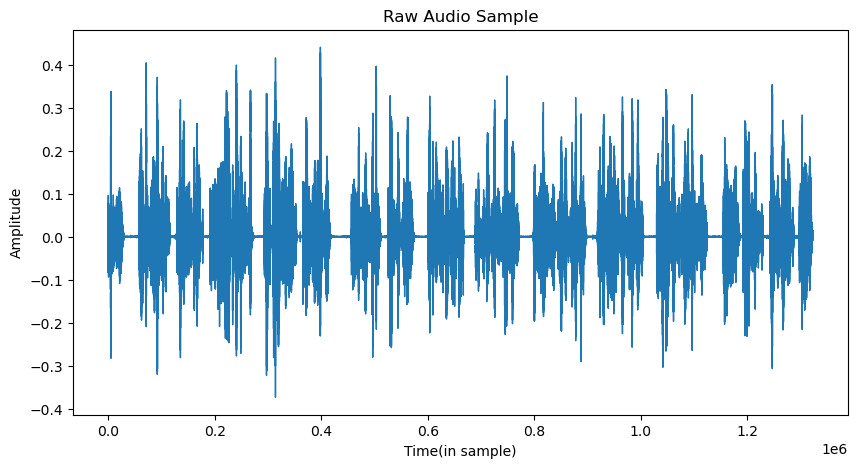

In [ ]:
pd.Series(y).plot(figsize=(10,5), lw=1, title='Raw Audio Sample')
plt.xlabel("Time(in sample)") #  0.2 is 9.07 sec(0.2/sr)
plt.ylabel("Amplitude") # loudness
plt.title("Raw Audio Sample")
plt.show()

<Axes: title={'center': 'Zoomed Raw Audio Sample'}>

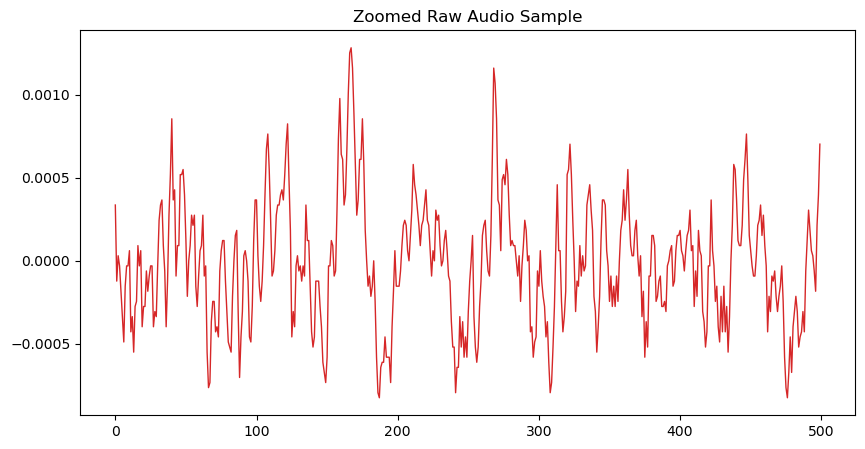

In [7]:
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.Series(y[30000:30500]).plot(figsize=(10,5), lw=1, title='Zoomed Raw Audio Sample', color=color_pal[3])

### Spectogram(frequencies)

In [8]:
D=librosa.stft(y)
sound_db= librosa.amplitude_to_db(np.abs(D),ref=np.max)
sound_db.shape

(1025, 2585)

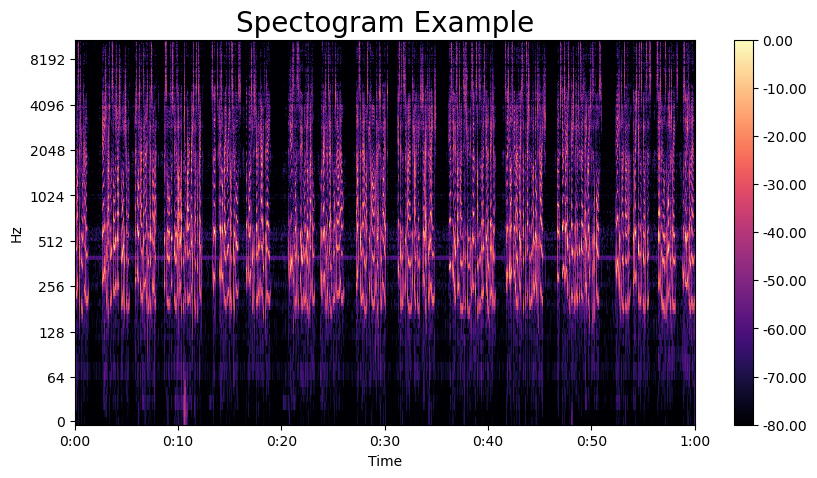

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
img=librosa.display.specshow(sound_db,x_axis='time',y_axis='log',ax=ax)
ax.set_title("Spectogram Example",fontsize=20)
fig.colorbar(img,ax=ax,format=f'%0.2f')
plt.show()

#### Nyquist Theorem
To correctly record a frequency F, the sampling rate must be at least 2 × F.

In [10]:
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = mfcc.mean(axis=1)  # compress time dimension
    return mfcc_mean


In [11]:
mfcc_feat = extract_mfcc(audio_files[0])
print(mfcc_feat.shape)  # (13,)

(13,)


### MFCC Extraction

In [12]:
X = []        # MFCC features
y_labels = [] # Speaker IDs

for file in audio_files:
    try:
        mfcc_feat = extract_mfcc(file)
        X.append(mfcc_feat)
        y_labels.append(os.path.basename(os.path.dirname(file)))
    except Exception as e:
        print("Skipping:", file)

# convert lists to numpy arrays
X = np.array(X)
y_labels = np.array(y_labels)

print("Feature shape:", X.shape)
print("Labels shape:", y_labels.shape)


Feature shape: (2511, 13)
Labels shape: (2511,)


In [13]:
print(X)

[[-3.5974280e+02  6.3167522e+01  1.1522049e+01 ... -7.1916437e+00
  -2.3099654e+00 -9.1560583e+00]
 [-3.3479056e+02  7.2036263e+01  9.2788496e+00 ... -8.2003565e+00
  -1.8992478e+00 -1.0531980e+01]
 [-3.5328546e+02  6.2818203e+01  1.0300251e+01 ... -7.0212150e+00
  -1.8490088e+00 -1.0112619e+01]
 ...
 [-3.9995407e+02  1.1926132e+02  2.1856899e+01 ... -5.6569252e+00
  -1.8921150e+00 -9.0500063e-01]
 [-3.9588495e+02  1.2238536e+02  2.3254177e+01 ... -4.1527276e+00
   7.6622345e-02 -3.3201535e+00]
 [-5.0832367e+02  6.1635998e+01  1.0832233e+01 ... -2.6715379e+00
   2.4749358e-01  3.2152042e+00]]


### Label Encoding

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

print("Encoded labels:", y_encoded[500:510])


Encoded labels: [12 12 12 12 12 12 12 12 12 12]


### Model Training

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [16]:
from sklearn.svm import SVC

model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

In [17]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9502982107355865
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.82      1.00      0.90         9
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         7
           5       0.90      1.00      0.95         9
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         6
          10       1.00      0.86      0.92         7
          11       1.00      1.00      1.00        11
          12       0.86      0.86      0.86         7
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         6
          16       0.80      1.00      0.89         

### Checking the pipeline

In [18]:
test_feat = extract_mfcc(audio_files[800]).reshape(1, -1)

predicted_label = model.predict(test_feat)[0]
speaker_name = le.inverse_transform([predicted_label])[0]

print("Identified Speaker:", speaker_name)


Identified Speaker: Speaker0046
